# Local PCA applied on the velocity

### Objective

The velocity of the ball is a piecewise linear function. One possible way to determine the parameters of the system is to use Local PCA.

***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

# different clustering methods
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture

%matplotlib inline

## Creating the dataset

The data is extracted from a CSV file and processed.

In [2]:
data = pd.read_csv('velocity_clean.csv', sep=',', header=None)
data.columns = ["t", "x", "y", "v"]
display(data) # t = time, x = horizontal position of the ball, y = height of the ball, v = vertical velocity of the ball
#data.head(20)

,t,x,y,v
0,0.000000,92,700,0.0
1,0.041667,91,701,24.0
2,0.083333,91,700,-24.0
3,0.125000,92,701,24.0
4,0.166667,92,702,24.0
...,...,...,...,...
84,4.375000,38,4,72.0
85,4.416667,38,3,-24.0
86,4.458333,39,2,-24.0
87,4.500000,39,2,0.0


In [3]:
n_init = 8 # number of first samples to be removed
n_data = data.shape[0] - n_init # number of samples (=81)

In [4]:
X = np.zeros((n_data,4))
X[:,0] = np.array(data.iloc[n_init:,0]) # time
X[:,1] = np.array(data.iloc[n_init:,1]) # horizontal position of the ball
X[:,2] = np.array(data.iloc[n_init:,2]) # height of the ball
X[:,3] = np.array(data.iloc[n_init:,3]) # velocity of the ball

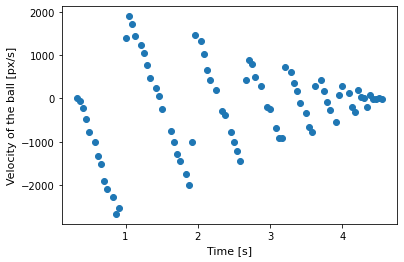

In [5]:
plt.scatter(X[:,0], X[:,3])
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Velocity of the ball [px/s]', fontsize=11)
plt.show()

Note that the velocity vector extracted from the CSV file was previously cleaned of outliers in MATLAB.

***

## Global PCA

Applying PCA to the global dataset leads to results that are far from those expected.

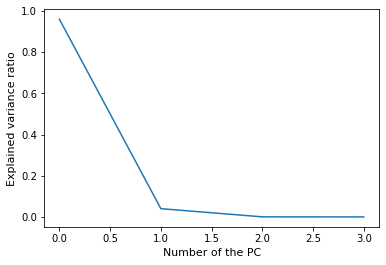

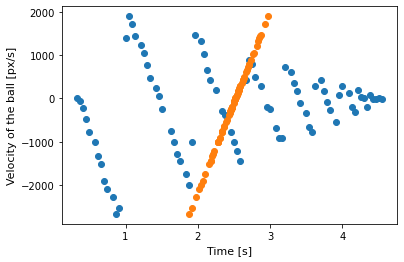

In [6]:
# Center the data
X_centered = X - np.mean(X, axis=0) # remove the average of the column ('axis=0')

# Create a PCA object and assign data
pca = PCA() # n_components=4
pca.fit(X_centered)

# Select the number of PCs to keep for reconstruction
L = pca.explained_variance_ratio_ # = percentage of variance that is attributed to each principal component

plt.plot(L)
plt.xlabel('Number of the PC', fontsize=11)
plt.ylabel('Explained variance ratio', fontsize=11)
plt.show()

q = 1 # choose to keep only the 1st PC because the contributions of the other PCs are negligible (see graph below)

A = pca.components_.T

# Encoder: Z = X A
Z = X_centered @ A

Aq = A[:,:q]
Zq = Z[:,:q] # OR Zq = X_centered @ Aq

# Decoder: X_reconstructed = Zq Aq.T
X_reconstructed = Zq @ Aq.T + np.mean(X, axis=0) # and de-centering the data

plt.scatter(X[:,0], X[:,3])
plt.scatter(X_reconstructed[:,0], X_reconstructed[:,3]) # plot the reconstruction from Global PCA
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Velocity of the ball [px/s]', fontsize=11)
plt.show()

***

## Clustering using DBSCAN

#### Sources
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556
- https://en.wikipedia.org/wiki/DBSCAN

Before clustering, the data must be centered and scaled (since X contains variables of different types).

In [7]:
ci = np.mean(X, axis=0) # average w.r.t. each variable (= column) => 'axis=0'
di = np.std(X, axis=0)  # auto-standard scaling
X_std = (X - ci) / di

K-Means minimizes the variances within the clusters (i.e. the squared Euclidean distances). It is very suitable for cloud data, but not in this case.

DBSCAN is another clustering method. It stands for "Density-Based Spatial Clustering of Applications with Noise" and is able to find arbitrary shaped clusters and clusters with noise (i.e. outliers). The main idea behind DBSCAN is that a point belongs to a cluster if it is close to many points from that cluster.

There are two key parameters of DBSCAN:
- eps: The distance that specifies the neighborhoods. Two points are considered to be neighbors if the distance between them are less than or equal to eps.
- min_samples: Minimum number of data points to define a cluster.

Labels:
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2 -1  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4]


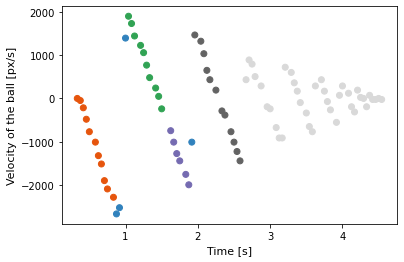

Number of clusters = 5


In [8]:
clustering = DBSCAN(eps=0.584, min_samples=3, metric='euclidean') # 0.98 & 5 (3 clusters) or 0.584 & 3 (5 clusters)
clustering.fit(X_std)
labels = clustering.labels_

print("Labels:\n" + str(labels)) # noisy samples are given the label -1 (in blue in the graph below)

plt.scatter(X[:,0], X[:,3], c=labels, cmap='tab20c')
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Velocity of the ball [px/s]', fontsize=11)
plt.show()

n_clusters = max(labels)+1
print("Number of clusters = " + str(n_clusters))

### Effect of outliers on clustering results

In order to observe the effect of data cleaning on clusters, we can use the same clustering method (DBSCAN) with the same parameters on the original uncleaned data.

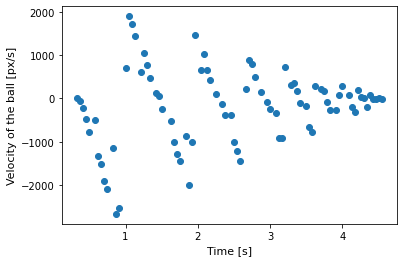

In [9]:
t = X[:,0]
h = X[:,2]

# Compute the velocity from the positions
V_vec = np.zeros((n_data,1)) # Initial velocity (index 0) will be zero
for i in range(1,n_data):
    dh = ( h[i] - h[i-1] ) / ( t[i] - t[i-1] )
    V_vec[i] = dh

plt.scatter(t, V_vec)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Velocity of the ball [px/s]', fontsize=11)
plt.show()

In [10]:
Y = np.zeros((n_data,4))
Y[:,0] = np.array(data.iloc[n_init:,0])
Y[:,1] = np.array(data.iloc[n_init:,1])
Y[:,2] = np.array(data.iloc[n_init:,2])
Y[:,3] = V_vec[:,0]

In [11]:
# Center and scale the dataset
ci = np.mean(Y, axis=0) # average w.r.t. each variable (= column) => 'axis=0'
di = np.std(Y, axis=0)  # auto-standard scaling
Y_std = (Y - ci) / di

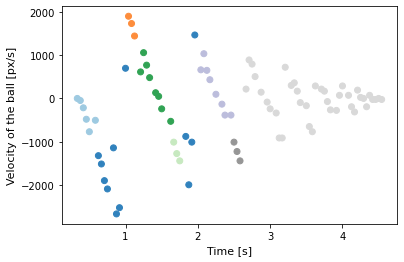

Number of clusters = 7


In [12]:
clustering2 = DBSCAN(eps=0.584, min_samples=3, metric='euclidean') # same parameters as before
clustering2.fit(Y_std)
labels2 = clustering2.labels_

plt.scatter(Y[:,0], Y[:,3], c=labels2, cmap='tab20c')
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Velocity of the ball [px/s]', fontsize=11)
plt.show()

print("Number of clusters = " + str(max(labels2)+1))

***

## Local PCA

Finally, we can apply PCA in each cluster.

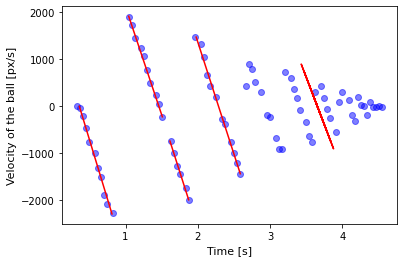

In [13]:
for i in range(n_clusters): # for each iteration/cluster: apply PCA locally
    
    # Select only the data of a single cluster (the one with label i)
    mask = (labels == i) # return a boolean array (= matrix with True/False)
    X_k = X[mask] # store in X_k only the elements for which mask=True
    
    # Center the data
    Xc = X_k - np.mean(X_k, axis=0) # remove the average of the column ('axis=0')
    
    # Create a PCA object and assign data
    pca = PCA()
    pca.fit(Xc)
    
    A = pca.components_.T
    Z = Xc @ A # Encode
    Aq = A[:,:q]
    Zq = Z[:,:q] # OR Zq = Xc @ Aq
    X_rec = Zq @ Aq.T + np.mean(X_k, axis=0) # Decode + De-centering the data
    
    # For each cluster, plot the reconstructed data from LPCA
    plt.scatter(X_k[:,0], X_k[:,3], c='b', alpha=0.5)
    plt.plot(X_rec[:,0], X_rec[:,3], c='r', alpha=1.0)

plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Velocity of the ball [px/s]', fontsize=11)
plt.show()

***

## Parameter estimation

From the Local PCA results, the parameters of the system can be estimated. Since the last cluster is poorly approximated by Local PCA, only the four first clusters are considered to estimate the parameters.

In [14]:
n_relevant = n_clusters - 1 # number of clusters that are relevant to consider for parameter estimation

# Find the beginning and end of each cluster

cluster_start = np.zeros((n_relevant,4))
cluster_end = np.zeros((n_relevant,4))

for i in range(n_relevant):
    
    # Select only the data of a single cluster (the one with label i)
    mask = (labels == i) # return a boolean array (= matrix with True/False)
    X_k = X[mask] # store in X_k only the elements for which mask=True
    
    start = np.where(X_k[:,3] == max(X_k[:,3])) # find the index of the maximum velocity in each cluster
    cluster_start[i] = X_k[start,:]
    
    end = np.where(X_k[:,3] == min(X_k[:,3])) # find the index of the minimum velocity in each cluster
    cluster_end[i] = X_k[end,:]

### Gravity estimation

The standard gravity $g$ can be estimated knowing that $-g$ is the slope of the curve of the velocity $v$ with respect to time $t$ (since $v(t) = v_0 - g t$).

In [15]:
g_vec = np.zeros((n_relevant,1))

for j in range(n_relevant):
    g_vec[j] = ( cluster_end[j,3] - cluster_start[j,3] ) / ( cluster_end[j,0] - cluster_start[j,0] ) # = dv/dt = -g

print(g_vec)

g = np.mean(g_vec)
print("g = " + str(g) + " px/s²")

[[-4560.        ]
 [-4660.36363636]
 [-4992.        ]
 [-4646.4       ]]
g = -4714.69090909093 px/s²


### Estimation of the coefficient of restitution

The coefficient of restitution $\rho$ is the ratio between the velocity of the ball just after the bounce and the velocity of the ball just before the bounce.

In [16]:
v0 = max(abs(cluster_start[0,3]),abs(cluster_end[0,3])) # maximum velocity in the 1st cluster
v1 = max(abs(cluster_start[1,3]),abs(cluster_end[2,3])) # maximum velocity in the 2nd and 3rd cluster
v2 = max(abs(cluster_start[3,3]),abs(cluster_end[3,3])) # maximum velocity in the 4th cluster

rho_vec = np.array([v1/v0, v2/v1])
print(rho_vec)

rho = np.mean(rho_vec)
print("rho = " + str(rho))

[0.87368421 0.73493976]
rho = 0.8043119847812328


### Validation by comparison with real-world values

In the video, the units used for length and time are pixels (px) and seconds (s), respectively. To be able to compare the length values of the video with reality, it is necessary to be able to convert pixels into meters. To do this, since we know the gravity factor in our real world and since the time units are the same in the video and in reality, the lengths can be converted as follows: $L_\text{meters} = \frac{9.81}{g} L_\text{pixels}$, with $g$ the standard gravity (in px) estimated earlier.

In [17]:
h0 = 0.5 * v0**2 / g  # initial height in px
h0_real = h0 * 9.81/g # actual initial height in meters
print("h0_real = " + str(h0_real) + " m")

h1 = 0.5 * v1**2 / g  # height of the first bounce in px
h1_real = h1 * 9.81/g # actual height of the first bounce in meters
print("h1_real = " + str(h1_real) + " m")

h2 = 0.5 * v2**2 / g  # height of the second bounce in px
h2_real = h2 * 9.81/g # actual height of the second bounce in meters
print("h2_real = " + str(h2_real) + " m")

h0_real = 1.1471025722406543 m
h1_real = 0.8756110382455256 m
h2_real = 0.47294943726399263 m


The heights obtained seem coherent with reality if we roughly estimate the actual heights using the meter visible in the video.

As for the value of the coefficient of restitution, the following [site](https://physics.stackexchange.com/questions/256468/model-formula-for-bouncing-ball) estimates it at $\rho = 0.75$ for a tennis ball, which is quite close to the result obtained here.